<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> CC3104 - Aprendizaje por Refuerzo 
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Laboratorio 8:</strong> Deep Reinforcement Learnign</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autores:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
        <li>Linda Inés Jiménez Vides - <strong>21169</strong></li>
        <li>Mario Antonio Guerra Morales - <strong>21008</strong></li>
      </ul>
    </td>
  </tr>
</table>

In [1]:
%pip install torch
%pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
# === Setup & Hiperparámetros (Inciso 4) ===
import math
import random
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from collections import deque
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Hiperparámetros Inciso 4
ENV_ID = "CartPole-v1"

# DQN
GAMMA = 0.99              # tasa de descuento
LR = 0.0001               # tasa de aprendizaje
BATCH_SIZE = 64           
BUFFER_CAPACITY = 10_000  # tamaño del replay buffer
TARGET_UPDATE_FREQ = 1000 # pasos para copiar pesos a la target network

# Entrenamiento
MAX_EPISODES = 500
MAX_STEPS_PER_EPISODE = 1000

# Exploración ε-greedy 
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY_STEPS = 20_000


In [ ]:
# === Ambiente de Gymnasium (Inciso 1) ===
env = gym.make(ENV_ID)
env.reset(seed=SEED)

obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

print(f"Ambiente: {ENV_ID}")
print(f"Dimensión del estado: {obs_dim}")
print(f"Número de acciones: {n_actions}")

Ambiente: CartPole-v1
Dimensión del estado: 4
Número de acciones: 2


In [ ]:
# === Red DQN (Inciso 2) y Consideraciones técnicas (Inciso 3) ===
class DQN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim),
        )

    def forward(self, x):
        return self.net(x)

policy_net = DQN(obs_dim, n_actions)
target_net = DQN(obs_dim, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
mse_loss = nn.MSELoss()

def epsilon_by_step(step: int):
    frac = min(1.0, step / EPS_DECAY_STEPS)
    return EPS_START + (EPS_END - EPS_START) * frac

def select_action(state: np.ndarray, global_step: int):
    eps = epsilon_by_step(global_step)
    if random.random() < eps:
        return env.action_space.sample(), eps
    with torch.no_grad():
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = policy_net(state_t)
        action = int(torch.argmax(q_values, dim=1).item())
        return action, eps


In [6]:
# === Replay Buffer (Experience Replay) — Inciso 2 ===
Transition = collections.namedtuple(
    "Transition", field_names=["state", "action", "reward", "next_state", "done"]
)

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states = torch.tensor(np.array([t.state for t in batch]), dtype=torch.float32)
        actions = torch.tensor([t.action for t in batch], dtype=torch.int64).unsqueeze(-1)
        rewards = torch.tensor([t.reward for t in batch], dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(np.array([t.next_state for t in batch]), dtype=torch.float32)
        dones = torch.tensor([t.done for t in batch], dtype=torch.float32).unsqueeze(-1)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
print("ReplayBuffer listo con capacidad:", BUFFER_CAPACITY)

ReplayBuffer listo con capacidad: 10000


In [7]:
# === Update step del DQN usando la Target Network — Inciso 2 ===
def dqn_update():
    if len(replay_buffer) < BATCH_SIZE:
        return 0.0

    states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

    # Q(s,a) actual de la policy_net
    q_values = policy_net(states).gather(1, actions)  # [batch,1]

    # Objetivo con la target_net (sin gradiente)
    with torch.no_grad():
        max_next_q = target_net(next_states).max(dim=1, keepdim=True)[0]
        target = rewards + (1.0 - dones) * GAMMA * max_next_q

    loss = mse_loss(q_values, target)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=10.0)  # clipping opcional
    optimizer.step()
    return float(loss.item())

In [8]:
# Parámetros de entrenamiento
EPISODES_TO_TRAIN = 600           
SOLVED_SCORE = 475.0              
LOG_EVERY = 10                    

reward_history = []
avg100_history = []
eps_history = []
loss_history = []
recent_rewards = deque(maxlen=100)

global_step = 0
best_avg100 = -float("inf")
start_time = time.time()

for ep in range(1, EPISODES_TO_TRAIN + 1):
    state, info = env.reset(seed=SEED + ep)
    ep_reward = 0.0
    ep_losses = []

    for t in range(MAX_STEPS_PER_EPISODE):
        action, eps = select_action(state, global_step)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Guardar transición en Replay Buffer
        replay_buffer.push(state, action, reward, next_state, done)

        # Avanzar estado y contadores
        state = next_state
        ep_reward += reward
        global_step += 1

        # Actualización del DQN
        loss = dqn_update()
        if loss:
            ep_losses.append(loss)

        # Sincronización periódica de la target network
        if global_step % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done:
            break

    reward_history.append(ep_reward)
    recent_rewards.append(ep_reward)
    avg100 = float(np.mean(recent_rewards))
    avg100_history.append(avg100)
    eps_history.append(eps)
    if len(ep_losses) > 0:
        loss_history.append(np.mean(ep_losses))

    if avg100 > best_avg100:
        best_avg100 = avg100

    if ep % LOG_EVERY == 0 or ep == 1:
        print(f"Ep {ep:4d} | R: {ep_reward:6.1f} | ε: {eps:5.3f} | "
              f"avg100: {avg100:6.1f} | buffer: {len(replay_buffer):5d} | step: {global_step}")

    # Criterio de parada temprana (si ya está resuelto)
    if best_avg100 >= SOLVED_SCORE and len(recent_rewards) == recent_rewards.maxlen:
        print(f"\n✅ Ambiente considerado resuelto: avg100={best_avg100:.1f} (≥ {SOLVED_SCORE}) en ep={ep}.")
        break

elapsed = time.time() - start_time
print(f"\nEntrenamiento finalizado en {ep} episodios, tiempo: {elapsed:.1f}s. "
      f"Mejor avg100: {best_avg100:.1f}")

Ep    1 | R:   18.0 | ε: 0.999 | avg100:   18.0 | buffer:    18 | step: 18
Ep   10 | R:   11.0 | ε: 0.989 | avg100:   23.1 | buffer:   231 | step: 231
Ep   20 | R:   33.0 | ε: 0.977 | avg100:   22.9 | buffer:   458 | step: 458
Ep   30 | R:   14.0 | ε: 0.967 | avg100:   22.5 | buffer:   675 | step: 675
Ep   40 | R:   19.0 | ε: 0.957 | avg100:   21.9 | buffer:   878 | step: 878
Ep   50 | R:   17.0 | ε: 0.945 | avg100:   22.2 | buffer:  1108 | step: 1108
Ep   60 | R:   18.0 | ε: 0.934 | avg100:   22.4 | buffer:  1341 | step: 1341
Ep   70 | R:   19.0 | ε: 0.923 | avg100:   22.4 | buffer:  1565 | step: 1565
Ep   80 | R:   14.0 | ε: 0.912 | avg100:   22.3 | buffer:  1787 | step: 1787
Ep   90 | R:   18.0 | ε: 0.902 | avg100:   21.9 | buffer:  1975 | step: 1975
Ep  100 | R:   21.0 | ε: 0.888 | avg100:   22.6 | buffer:  2260 | step: 2260
Ep  110 | R:   36.0 | ε: 0.874 | avg100:   23.1 | buffer:  2543 | step: 2543
Ep  120 | R:   28.0 | ε: 0.859 | avg100:   23.9 | buffer:  2846 | step: 2846
Ep  1

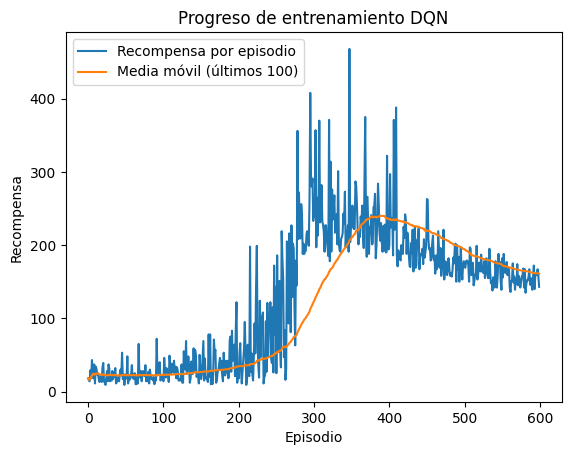

In [9]:
plt.figure()
plt.plot(reward_history, label="Recompensa por episodio")
plt.plot(avg100_history, label="Media móvil (últimos 100)")
plt.title("Progreso de entrenamiento DQN")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.legend()
plt.show()